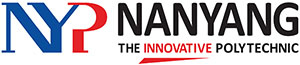

# IT3386 - AI Services in Analytics

## Part 1 - Data Preparation

This template contains some steps to help you complete your assignment. Refer to the assignment brief for details on the tasks you are required to perform and add them into the notebook accordingly.


## 1. Business Case

#### Introduction
Airport security is a critical component of global air travel, tasked with the responsibility of inspecting billions of pieces of luggage annually. The manual operation of X-ray screening systems is both monotonous and requires intense concentration, leading to significant miss rates for prohibited items. As air travel continues to grow, there is a pressing need for innovative solutions to enhance security measures while improving operational efficiency. 

To put the scale of the challenge into perspective:

- **Global Passenger Volume:** In 2019, global airports handled approximately 4.5 billion passengers, translating to around 6.75 billion pieces of luggage screened annually, assuming an average of 1.5 bags per passenger.
- **Carry-On Screening:** In 2022, the Transportation Security Administration (TSA) screened over 1.9 billion carry-on bags alone.

Given this vast volume, it is crucial to explore solutions that can automate the screening process. Human operators face several limitations:

- **Time Constraints:** Security officers have only 3-5 seconds on average to decide if a bag contains a threat.
- **Human Error:** Visual fatigue and monotony can lead to a miss rate of up to 20% for prohibited items.
- **Stress Factors:** The stressful nature of the job decreases concentration over time, increasing error rates.


#### Related Research

There have been several notable advancements in the field of AI-assisted baggage screening. Some of the key research efforts include:

1. **"Identify Harmful Objects in X-Ray Image of Baggages"** by Bajaj and Pandey (2021)  
   This study proposes an object detection algorithm using Faster R-CNN for X-ray baggage security screening images. It focuses on detecting dangerous items such as firearms and knives within X-ray images.

2. **"Efficient X-ray Security Images for Dangerous Goods Detection Based on Improved YOLOv7"** (2023)  
   This research presents a high-accuracy dangerous goods detection algorithm for X-ray security images, utilizing the YOLOv7 framework to improve detection speed and accuracy.

3. **"Can AI Detect Prohibited Items from Dual-view X-ray Images?"** (2023)  
   This paper introduces the Large-scale Dual-view X-ray (LDXray) dataset and proposes the Auxiliary-view Enhanced Network (AENet) to detect prohibited items using dual-view X-ray images, expanding the detection capabilities of AI-based systems.

While these solutions are valuable, no publicly available solutions which have explored the use of AutoML for building such systems. This proposal aims to fill that gap by investigating the potential of AutoML in developing AI models for airport security, democratizing access to advanced AI tools and making it easier for users with limited technical expertise to create such solutions.


#### Proposed Solution

We propose developing an AI object detection model tailored specifically to identify high-risk items in X-ray images of baggage. This solution will focus on detecting four of the most dangerous items that can cause serious harm:

- **Gun**
- **Blade**
- **Shuriken**
- **Knife**

By narrowing the focus to these high-risk items, the model can provide significant security enhancements while keeping implementation costs manageable. The use of AutoML will allow users to build, train, and deploy these models more easily, making this solution accessible to a wider range of airports, regardless of their technical capacity.


#### Benefits and Cost Savings
AI-assisted screening technology offers substantial benefits for airport security and operations. By improving detection accuracy by 70-90%, AI can significantly reduce missed threats, such as firearms, which have been increasingly found by the TSA. Key benefits include:

- **Increased Efficiency:** Automated screening can boost passenger throughput by 30-50%, allowing large airports to handle thousands more passengers daily without the need for additional staff.
- **Cost Savings:** Reduced false alarms can save up to $500,000 annually, while optimized staff usage may lead to labor cost reductions in the millions.
- **Time Savings:** Faster bag inspections can save over 40 hours per day for medium-sized airports, enhancing operational efficiency and increasing passenger satisfaction by up to 60%.
- **Enhanced Security:** AI models can improve detection accuracy, reducing the risk of security threats such as weapons and prohibited items entering airports. This also fosters better compliance with safety regulations, increasing passenger trust.
- **Business Case:** Improved security, increased operational efficiency, and significant cost savings make this a compelling business case for airports of all sizes. As AI technology continues to evolve, its benefits will likely increase, potentially revolutionizing airport security processes globally.

This approach has the potential to drive faster, more cost-effective deployments of security measures, ultimately enhancing safety, operational efficiency, and overall airport performance.

#### Conclusion

AI-driven X-ray image detection offers a promising solution to enhance airport security by improving threat detection, increasing operational efficiency, and reducing costs. By focusing on high-risk items such as guns, blades, and knives, and leveraging AutoML to make the technology accessible to more airports, we can significantly enhance security measures while streamlining operations. This approach not only makes airports safer but also provides substantial cost savings and efficiency gains, making it a valuable investment for airports worldwide.

## 2.1 Data Preparation

Main Tasks (refer to assignment brief for a complete list of tasks)
- Prepare images according to project criteria
- Perform image pre-processing
- Draw bounding boxes
- ...
- Prepare Annotation file
- Check bounding boxes of normalised vertices
- Ensure local directory contains images and annotation file

### 2.1.1 Importing Packages

In [353]:
# %pip install roboflow
# %pip install python-dotenv

In [354]:
import os
from tqdm import tqdm
import shutil
from pprint import pprint
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import random
from roboflow import Roboflow
from dotenv import load_dotenv, find_dotenv
import warnings
from sklearn.utils import shuffle
import cv2

from google.cloud import storage


load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)


RF_KEY = os.environ.get("ROBOFLOW_API_KEY")

### 2.1.2 Downloading Dataset

Link to the dataset: https://universe.roboflow.com/gmrit/threat-detection-9yn3r

To label the images, I forked the dataset into my own project and labelled 5 random images.

In [355]:
def download_dataset(rf, project, version, download_format="voc"):
    download_path = os.path.join(os.getcwd(), "Threat-Detection-1")

    if os.path.exists(download_path):
        print(f"Dataset already exists at: {download_path}")
        return download_path

    print(f"Downloading dataset to {download_path}...")
    dataset = version.download(download_format)
    
    return dataset.location


rf = Roboflow(api_key=RF_KEY)
project = rf.workspace("gmrit").project("threat-detection-9yn3r")
version = project.version(1)

destination_path = download_dataset(rf, project, version)
destination_path

loading Roboflow workspace...
loading Roboflow project...
Dataset already exists at: /Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1


'/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1'

### 2.1.3 Labelling Images


* INSERT IMAGE HERE

- Ensure bounding boxes are as tight as possible around the object, accurately capturing its shape.
- Maintain consistent labeling across all objects.
- For partially visible or truncated objects, draw the bounding box only around the visible portion.
- When objects are overlapping or occluded, draw separate bounding boxes for each distinct visible object, rather than enclosing the entire group in a single box. This ensures the model can clearly differentiate between individual objects.


source: 
- https://www.ayadata.ai/bounding-boxes-in-computer-vision-uses-best-practices-for-labeling-and-more/
- https://www.v7labs.com/blog/bounding-box-annotation

### 2.1.4 Partitioning Dataset

In [369]:
# create a dataframe with the filename + labels
# this is done for easier visualization and simplifies the process of keeping track of all the files

meta_df_cols = ['bag_id', 'file_path', 'split_label', 'object_label', 'coordinates_arr']
meta_df = pd.DataFrame(columns=meta_df_cols)
meta_df.head()

,bag_id,file_path,split_label,object_label,coordinates_arr


In [370]:
# since we downloaded the dataset in pascal VOC format, there is information of the object label and the bounding box in the XML files that we need to extract
# below is a function I created to parse the xml files and get this information out

def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        objects.append({
            "label": label,
            "bbox": [xmin, ymin, xmax, ymax]
        })
    
    return objects

In [371]:
data = []
for root, dirs, files in os.walk(destination_path):
    for file in files:
        if file.endswith('.xml'):
            file_path = os.path.join(root, file)
            bag_id = os.path.splitext(file)
            split_label = os.path.basename(root)

            jpg_file_path = os.path.join(root, f"{bag_id[0]}.jpg")
            objects = parse_voc_annotation(file_path)

            for obj in objects:
                data.append({
                    'bag_id': bag_id[0].split(".")[0][:-4],
                    'file_path': jpg_file_path,
                    'split_label': split_label,
                    'object_label': obj['label'],
                    'coordinates_arr': obj['bbox']
                })


meta_df = pd.DataFrame(data, columns=meta_df_cols)
meta_df.head()

,bag_id,file_path,split_label,object_label,coordinates_arr
0,BAG_0853,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0853_png.rf.716ea1cff9a7f02ccb079f7b176b3e03.jpg,valid,SHURIKEN,"[94, 313, 280, 543]"
1,BAG_0853,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0853_png.rf.716ea1cff9a7f02ccb079f7b176b3e03.jpg,valid,BLADE,"[380, 212, 432, 326]"
2,BAG_0107,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0107_png.rf.b4e49b50080ce7b603d9eb24f58a28e2.jpg,valid,GUN,"[269, 141, 520, 412]"
3,BAG_0427,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0427_png.rf.09c1cc0bd68817a2a9e0f40a49a8db15.jpg,valid,BLADE,"[206, 245, 263, 404]"
4,BAG_0779,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0779_png.rf.cb2944abe0ef85f6f75638ac3e80d835.jpg,valid,SHURIKEN,"[269, 76, 428, 271]"


In [372]:
meta_df = meta_df[~(meta_df['object_label'] == 'SCREW')] # excluding the fifth class 'screw'
meta_df.object_label.value_counts()

object_label
GUN         1779
BLADE       1603
SHURIKEN     690
KNIFE        163
Name: count, dtype: int64

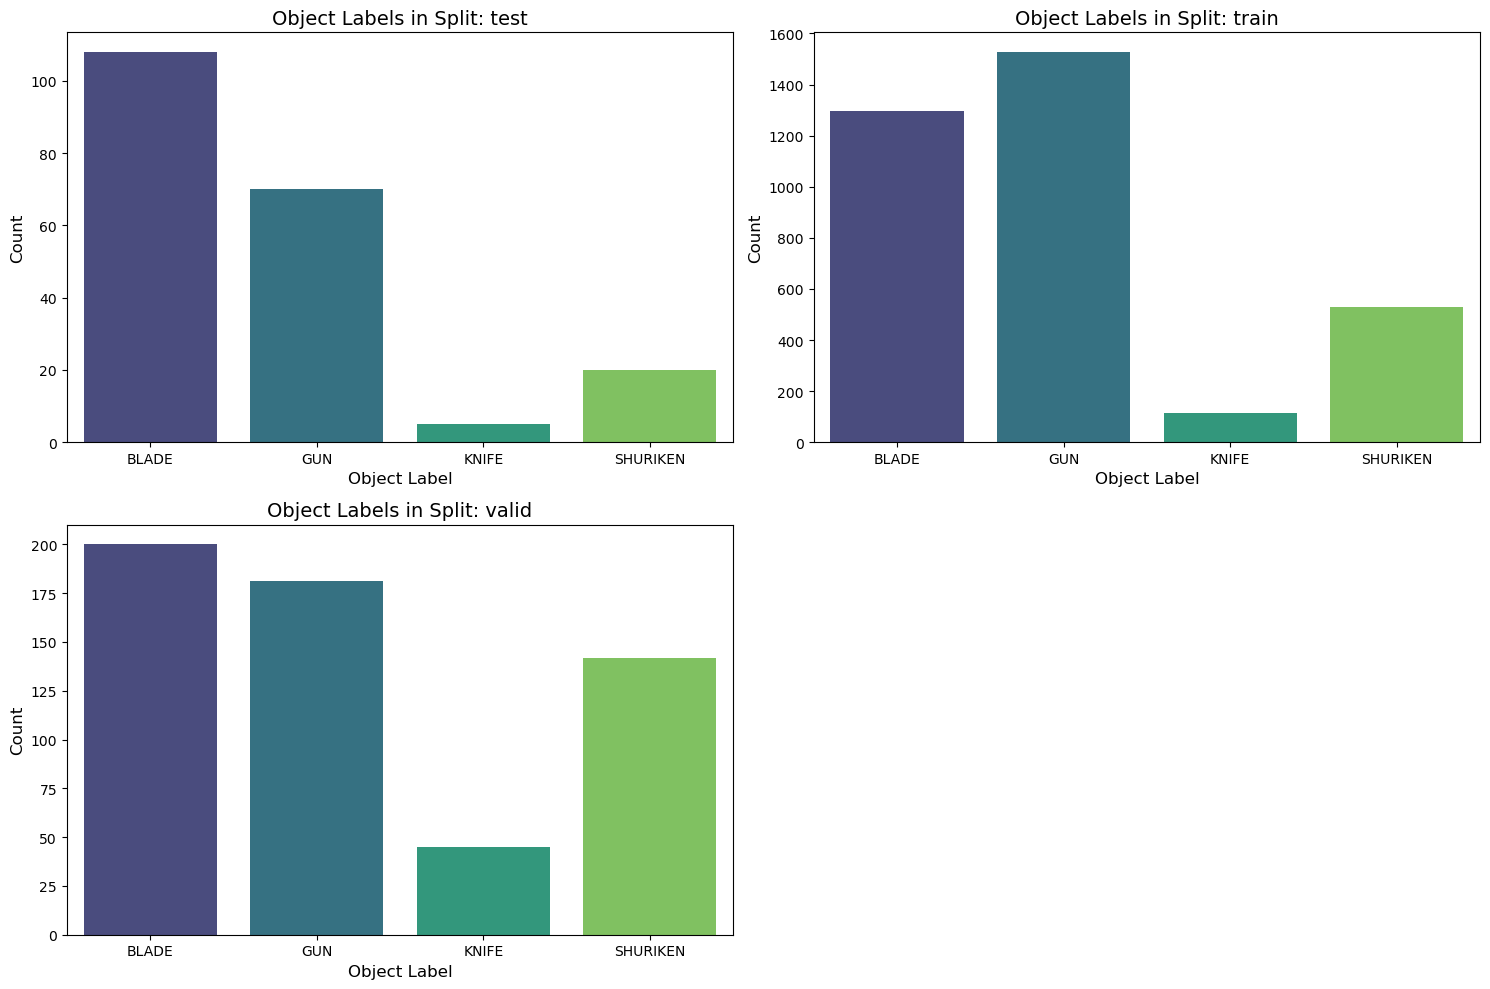

In [373]:
grouped_data = meta_df.groupby(['split_label', 'object_label']).size().reset_index(name='count')
split_labels = grouped_data['split_label'].unique()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(split_labels):
        split_data = grouped_data[grouped_data['split_label'] == split_labels[i]]
        sns.barplot(
            data=split_data,
            x='object_label',
            y='count',
            ax=ax,
            palette='viridis',
        )
        ax.set_title(f'Object Labels in Split: {split_labels[i]}', fontsize=14)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_xlabel('Object Label', fontsize=12)
    else:
        ax.axis('off')

plt.tight_layout()

plt.show()

In [374]:
meta_df[meta_df["bag_id"] == "BAG_0001"]

,bag_id,file_path,split_label,object_label,coordinates_arr
1565,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.b5e7aba3b1d8f9ae223c6ab62c0daa08.jpg,train,BLADE,"[141, 296, 237, 382]"
1781,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.b6e6df5911c84777ba45d21f302ba746.jpg,train,BLADE,"[404, 293, 498, 388]"
2011,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.4f20bdbc3204f8c4ec928f6c7f8d3eae.jpg,train,BLADE,"[144, 293, 238, 388]"
2058,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.a91374404d122c2793f2331ec240cbeb.jpg,train,BLADE,"[144, 254, 238, 349]"
4424,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.f47cab41fa61d173d9e13a006ca9f062.jpg,train,BLADE,"[141, 261, 237, 347]"
4476,BAG_0001,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0001_png.rf.e5d34438a02759d78c1d395c99608f24.jpg,train,BLADE,"[405, 296, 501, 382]"


<div class="alert alert-info" role="alert">
From this it can be seen that each bag can have multiple images, further inspecting it its actually that the same bag shot at different angles. The bag itself has been rotated in a 3d space with the object being captured from all different angles along x, y and z axis.
    
<br>
<br>

This is good for us since we would not need to apply any kind of image augmentation steps since there are multiple variations of the image already (at least in terms of image repositioning, we can still augment based on color if required and when building a custom model, for the scope of this project it will be ignored).<br>

This means that the data set is quite diverse and will allow the model to generalize quite effectively. 
</div>

In [375]:
def filter_small_bounding_boxes(meta_df):
    def calculate_area(coords):
        xmin, ymin, xmax, ymax = coords
        width = xmax - xmin
        height = ymax - ymin
        return width * height
    
    meta_df['bbox_area'] = meta_df['coordinates_arr'].apply(calculate_area)
    filtered_df = meta_df[meta_df['bbox_area'] >= 64].copy()
    filtered_df.drop(columns=['bbox_area'], inplace=True)

    return filtered_df

meta_df = filter_small_bounding_boxes(meta_df)
meta_df.head()

,bag_id,file_path,split_label,object_label,coordinates_arr
0,BAG_0853,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0853_png.rf.716ea1cff9a7f02ccb079f7b176b3e03.jpg,valid,SHURIKEN,"[94, 313, 280, 543]"
1,BAG_0853,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0853_png.rf.716ea1cff9a7f02ccb079f7b176b3e03.jpg,valid,BLADE,"[380, 212, 432, 326]"
2,BAG_0107,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0107_png.rf.b4e49b50080ce7b603d9eb24f58a28e2.jpg,valid,GUN,"[269, 141, 520, 412]"
3,BAG_0427,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0427_png.rf.09c1cc0bd68817a2a9e0f40a49a8db15.jpg,valid,BLADE,"[206, 245, 263, 404]"
4,BAG_0779,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/valid/BAG_0779_png.rf.cb2944abe0ef85f6f75638ac3e80d835.jpg,valid,SHURIKEN,"[269, 76, 428, 271]"


<div class="alert alert-info" role="alert">
In this step we are filtering out all those labels where the bounding box is smaller than 8 x 8 size. Small bounding box size will not contribute much to the predictions as well. 
</div>

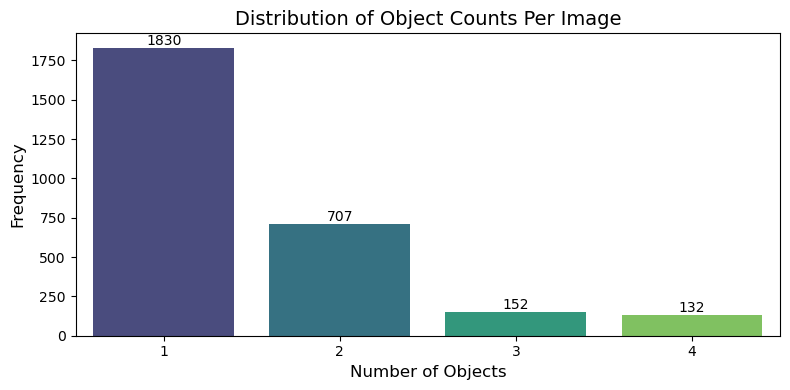

In [376]:
object_counts = meta_df.groupby('file_path').size().reset_index(name='object_count')
value_counts = object_counts['object_count'].value_counts()

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    x=value_counts.index,
    y=value_counts.values,
    palette='viridis'
)

for i, value in enumerate(value_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Distribution of Object Counts Per Image', fontsize=14)
plt.xlabel('Number of Objects', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
For training, it is best practice to have generally 1 - 2 labels so that the model can easily differentiate between the multiple instances. <br><br>
Those images with 3 - 4 objects will be used for the testing dataset.
</div>

In [377]:
image_label_counts = meta_df.groupby('file_path')['object_label'].count().reset_index()
image_label_counts.columns = ['file_path', 'label_count']
filtered_images = image_label_counts['file_path']

filtered_meta_df = meta_df[meta_df['file_path'].isin(filtered_images)]
filtered_meta_df.object_label.value_counts()

object_label
GUN         1776
BLADE       1599
SHURIKEN     690
KNIFE        163
Name: count, dtype: int64

In [382]:
# I will make a new dataframe with the images that will be used for the trainining+validation and testing
# To make this, we can leverage the meta df that was created with all the image info + bounding boxes

In [384]:
def get_train_images(meta_df, filtered_images, max_samples_per_label=50, random_state=42):
    filtered_meta_df = meta_df[meta_df['file_path'].isin(filtered_images)].copy()
    np.random.seed(random_state)
    
    file_label_map = filtered_meta_df.groupby('file_path')['object_label'].apply(set)
    file_label_counts = file_label_map.apply(len)
    
    # prioritize KNIFE and files with fewer labels
    sorted_files = sorted(
        file_label_map.index, 
        key=lambda x: (
            0 if 'KNIFE' in file_label_map[x] else 1, 
            file_label_counts[x]
        )
    )
    
    # sample balanced dataset
    sampled_files = set()
    result_df_parts = []
    label_sample_counts = {}
    
    for file in sorted_files:
        if file in sampled_files:
            continue
        
        file_labels = file_label_map[file]
        
        # check if all labels can be sampled
        if all(
            (label_sample_counts.get(l, 0) if l in label_sample_counts else 0) < max_samples_per_label 
            for l in file_labels
        ):
            file_data = filtered_meta_df[filtered_meta_df['file_path'] == file]
            result_df_parts.append(file_data)
            sampled_files.add(file)
            
            # updating the label counts
            for l in file_labels:
                label_sample_counts[l] = label_sample_counts.get(l, 0) + 1
    
    # combining and shuffle results
    if result_df_parts:
        train_df = pd.concat(result_df_parts).drop_duplicates(subset=['file_path', 'object_label'])
        train_df = shuffle(train_df, random_state=random_state)
    
        label_counts = train_df['object_label'].value_counts()
        print("Final Label Counts:")
        print(label_counts)
        print(f"Total unique images: {train_df['file_path'].nunique()}")
        print(f"Avg labels per image: {train_df.groupby('file_path')['object_label'].nunique().mean():.2f}")
        
        return train_df
    else:
        print("No samples could be selected.")
        return pd.DataFrame()
    
    
train_df = get_train_images(meta_df, filtered_images)
train_df.head()

Final Label Counts:
object_label
GUN         50
KNIFE       50
BLADE       50
SHURIKEN    50
Name: count, dtype: int64
Total unique images: 143
Avg labels per image: 1.40


,bag_id,file_path,split_label,object_label,coordinates_arr
4747,BAG_0488,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0488_png.rf.7a2d66a2970a8f5a9756a2115bf7ae4a.jpg,train,GUN,"[171, 15, 461, 360]"
2064,BAG_0097,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0097_png.rf.6046d82290018f2373515b6fa76db364.jpg,train,KNIFE,"[233, 479, 449, 580]"
1567,BAG_0168,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0168_png.rf.b4e34b6fc9175aecfca5a0d33206ac9b.jpg,train,GUN,"[24, 257, 184, 522]"
755,BAG_1431,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_1431_png.rf.d3300d62583a3e3ce72616964aadd7b7.jpg,test,BLADE,"[153, 230, 225, 358]"
804,BAG_0979,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/test/BAG_0979_png.rf.01f26c5faf5c8f9a9bf36c3bc2e7cbc5.jpg,test,BLADE,"[293, 380, 363, 493]"


In [385]:
def get_test_images(meta_df, train_df, n_test_images=10):
    available_images = meta_df[~meta_df['file_path'].isin(train_df['file_path'])]
    
    unique_labels = available_images['object_label'].unique()
    selected_images = []
    
    for label in unique_labels:
        label_images = available_images[available_images['object_label'] == label]
        if not label_images.empty:
            selected_images.append(label_images.sample(n=1))
    
    remaining_needed = n_test_images - len(selected_images)
    if remaining_needed > 0:
        remaining_images = available_images[~available_images['file_path'].isin([img['file_path'].iloc[0] for img in selected_images])]
        additional_images = remaining_images.sample(n=remaining_needed)
        selected_images.append(additional_images)
    
    test_df = pd.concat(selected_images).reset_index(drop=True)
    
    print(f"Total unique images in test_df: {test_df['file_path'].nunique()}")
    print(f"Label distribution in test_df:\n{test_df['object_label'].value_counts()}")
    
    return test_df

test_df = get_test_images(meta_df, train_df, n_test_images=10)
test_df.head()

Total unique images in test_df: 10
Label distribution in test_df:
object_label
GUN         5
BLADE       3
SHURIKEN    1
KNIFE       1
Name: count, dtype: int64


,bag_id,file_path,split_label,object_label,coordinates_arr
0,BAG_0684,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0684_png.rf.8bbc6490ddd5bdb7bef7aedd16fddd53.jpg,train,SHURIKEN,"[131, 312, 261, 535]"
1,BAG_1459,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_1459_png.rf.3461c8af569288396254d207bcedda4a.jpg,train,BLADE,"[354, 161, 435, 293]"
2,BAG_0843,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0843_png.rf.4a0986dfb1353403329b56807ddac0c5.jpg,train,GUN,"[185, 227, 358, 515]"
3,BAG_0736,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_0736_png.rf.2f9637b008c06cdbb37c7249a0746556.jpg,train,KNIFE,"[167, 51, 240, 392]"
4,BAG_1068,/Users/daaa/Downloads/NYP_Y3S2_Assignments/AI_Services_in_Analytics_Assignment/Threat-Detection-1/train/BAG_1068_png.rf.f0195177544502f0394e82021f8862f1.jpg,train,GUN,"[144, 1, 417, 125]"


In [289]:
train_image_set = set(train_df['file_path'])
test_image_set = set(test_df['file_path'])

assert train_image_set.isdisjoint(test_image_set), "Train and Test images overlap!"

In [290]:
print(f"Training set: {len(train_df)} bounding boxes, {train_df['file_path'].nunique()} unique images, {train_df['file_path'].count()} total images.")
print(f"Test set: {len(test_df)} bounding boxes, {test_df['file_path'].nunique()} unique images, {test_df['file_path'].count()} total images.")

Training set: 200 bounding boxes, 143 unique images, 200 total images.
Test set: 10 bounding boxes, 10 unique images, 10 total images.


<div class="alert alert-info" role="alert">
There are now 50 bounding boxes for each of the objects in the dataset with 143 unique images and in total 200 images.
</div>

<div class="alert alert-info" role="alert">
Testing dataset is created with 10 unique images and 18 bounding boxes (some of the images have 3 - 4 bounding boxes). 
    
`assert train_image_set.isdisjoint(test_image_set), "Train and Test images overlap!"`
is also used to check that the train images are not appearing in the test images, preventing data leakage. 
</div>

### 2.1.5 Data Preparation

- image resizing
- resize bounding box
- normalize bounding box
- normalization of image
- contrast adjustment
- combining everything and creating annotation csv file


Additional Considerations: 
- filtering down those images with bounding box sizes smaller than  8 pixels by 8 pixels.

In [386]:
# sample image to run the transformations

rand_idx = random.randrange(0, len(train_df))

image = cv2.imread(train_df.iloc[rand_idx].file_path)
image_size = image.shape[:2]
print(rand_idx, image_size)

20 (640, 640)


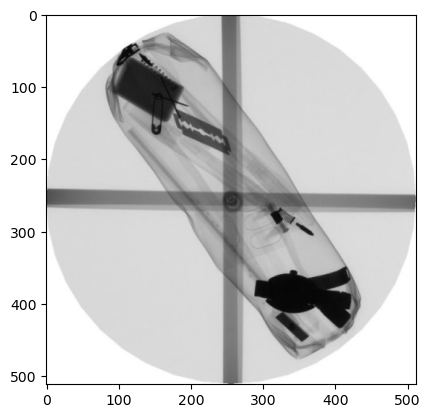

In [387]:
# image resizing

def resize_image(image, target_size):
    original_size = image.shape[:2]
    if target_size[0] > original_size[1] or target_size[1] > original_size[0]:
        interpolation = cv2.INTER_CUBIC
    else:
        interpolation = cv2.INTER_AREA
    
    resized_image = cv2.resize(image, target_size, interpolation=interpolation)
    return resized_image


target_size = (512, 512)
resized_img = resize_image(image, target_size=target_size)
plt.imshow(resized_img)

<div class="alert alert-info" role="alert">
The image was resized to 512 x 512 to ensure consistency among all the images and the size chosen ensures that the image does not loose too much of its quality. The sqaure shape ensures that the  aspect ratio is 1:1. 
<br><br>
Since most of the images are not too different in terms of shape (very similar in height and width), the aspect ratio would still be maintained despite the resizing. 
</div>

In [388]:
original_bbox = train_df.iloc[rand_idx].coordinates_arr
original_bbox

[218, 161, 322, 246]

In [389]:
# resizing the bounding box
# this is done to allign with the resized image

def resize_bounding_box(bbox, original_size, target_size):
    xmin, ymin, xmax, ymax = bbox
    original_width, original_height = original_size
    target_width, target_height = target_size

    new_xmin = xmin * target_width / original_width
    new_ymin = ymin * target_height / original_height
    new_xmax = xmax * target_width / original_width
    new_ymax = ymax * target_height / original_height

    new_bbox = [new_xmin, new_ymin, new_xmax, new_ymax]
    return new_bbox


new_bbox = resize_bounding_box(original_bbox, image_size, target_size)
print("ORIGINAL BOUNDING BOX:", original_bbox)
print("NEW BOUNDING BOX:", new_bbox)

ORIGINAL BOUNDING BOX: [218, 161, 322, 246]
NEW BOUNDING BOX: [174.4, 128.8, 257.6, 196.8]


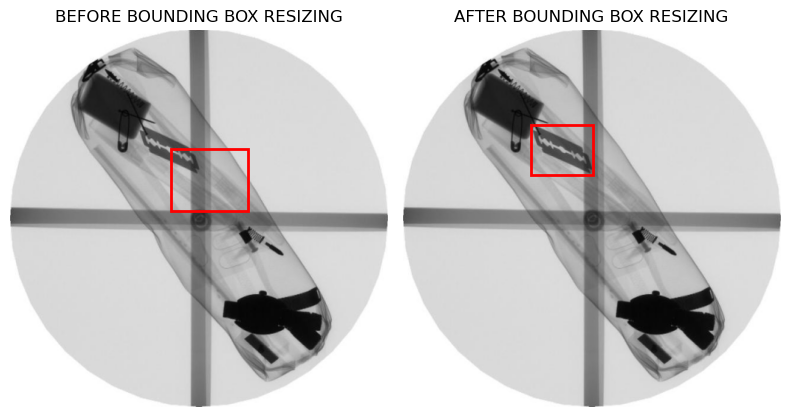

In [390]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

axs[0].imshow(resized_img)
axs[0].set_title('BEFORE BOUNDING BOX RESIZING')
axs[0].add_patch(plt.Rectangle((original_bbox[0], original_bbox[1]), 
                                   original_bbox[2] - original_bbox[0], 
                                   original_bbox[3] - original_bbox[1], 
                                   edgecolor='red', facecolor='none', linewidth=2))
axs[0].axis('off')

resized_image = cv2.resize(image, target_size)

axs[1].imshow(resized_img)
axs[1].set_title('AFTER BOUNDING BOX RESIZING')
axs[1].add_patch(plt.Rectangle((new_bbox[0], new_bbox[1]), 
                                   new_bbox[2] - new_bbox[0], 
                                   new_bbox[3] - new_bbox[1], 
                                   edgecolor='red', facecolor='none', linewidth=2))
axs[1].axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
As seen in the above image, adjusting the bounding box is crucial to prevent the model from capturing the wrong patterns and information. 
</div>

In [391]:
def normalize_bounding_box(bbox, image_size):
    xmin, ymin, xmax, ymax = bbox
    width, height = image_size

    normalized_bbox = [xmin / width, ymin / height, xmax / width, ymax / height]
    return normalized_bbox

n_new_bbox = normalize_bounding_box(new_bbox, target_size)

print("NORMALIZED BOUDING BOX:", n_new_bbox)

NORMALIZED BOUDING BOX: [0.340625, 0.2515625, 0.503125, 0.384375]


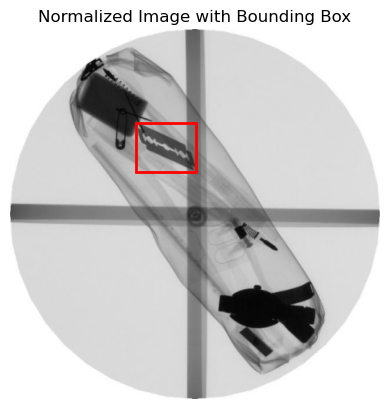

In [392]:
# display the normalized image and bounding box

plt.imshow(resized_image)

# converting the normalized_bbox values to pixel coordinates for plotting
bbox_pixel_coords = (
    n_new_bbox[0] * target_size[0],  # xmin in pixels
    n_new_bbox[1] * target_size[1],  # ymin in pixels
    (n_new_bbox[2] - n_new_bbox[0]) * target_size[0],  # width in pixels
    (n_new_bbox[3] - n_new_bbox[1]) * target_size[1]   # height in pixels
)


rect = plt.Rectangle(
    (n_new_bbox[0] * resized_img.shape[1], n_new_bbox[1] * resized_img.shape[0]), 
    (n_new_bbox[2] - n_new_bbox[0]) * resized_img.shape[1], 
    (n_new_bbox[3] - n_new_bbox[1]) * resized_img.shape[0], 
    edgecolor='red', facecolor='none', linewidth=2
)

plt.gca().add_patch(rect)

plt.title("Normalized Image with Bounding Box")
plt.axis('off')
plt.show()

<div class="alert alert-info" role="alert">
The google vertex ai service requires that the bounding boxes are normalized. 
</div>

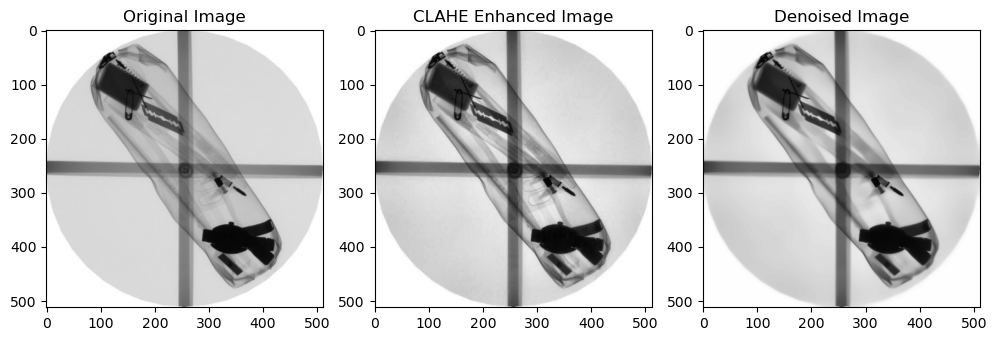

In [393]:
def adjust_contrast(image, clip_limit=2, tile_grid_size=(8, 8)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if gray.dtype != 'uint8':
        gray = (gray * 255).astype('uint8')
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_image = clahe.apply(gray)
    img_3ch = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2BGR)
    return img_3ch

clahe_img = adjust_contrast(resized_img)

denoised_img = cv2.fastNlMeansDenoisingColored(clahe_img,None,10,10,7,21)


# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(clahe_img, cv2.COLOR_BGR2RGB))
plt.title('CLAHE Enhanced Image')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
plt.title('Denoised Image')

plt.tight_layout()
plt.show()

<div class="alert alert-info" role="alert">
CLAHE (Contrast Limited Adaptive Histogram Equalization) enhances image contrast by adjusting local brightness, improving details in low-contrast areas. 
    
Image denoising reduces noise, helping to clarify important features and improve the quality of the image for analysis.
    
The transformations applied make it easier to identify the objects even in low quality images
</div>

[0.340625, 0.2515625, 0.503125, 0.384375]



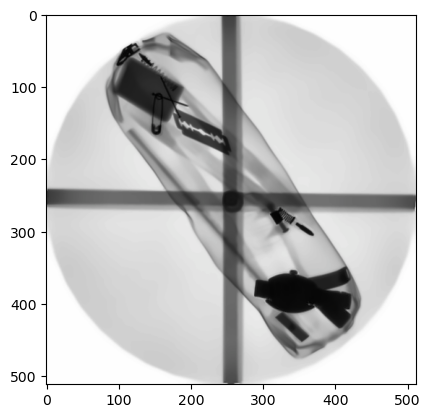

In [394]:
# combining everything into a pipeline

def process_image(image, bbox, target_size, clip_limit=2.0, tile_grid_size=(8, 8)):
    original_size = image.shape[:2][::-1]
    
    resized_image = resize_image(image, target_size)

    resized_bbox = resize_bounding_box(bbox, original_size, target_size)
    
    clahe_img = adjust_contrast(resized_image, clip_limit=clip_limit, tile_grid_size=tile_grid_size)
    
    denoised_img = cv2.fastNlMeansDenoisingColored(clahe_img, None, 10, 10, 7, 21)

    normalized_bbox = normalize_bounding_box(resized_bbox, target_size)

    return denoised_img, normalized_bbox

img = cv2.imread(train_df.iloc[rand_idx].file_path)
original_bbox = train_df.iloc[rand_idx].coordinates_arr

tmp, norm_bbox = process_image(img, original_bbox, target_size)

print(norm_bbox, end="\n\n")

plt.imshow(tmp)

In [395]:
def csvmaker(dataframe, target_size, clip_limit=2.0, tile_grid_size=(8, 8)):
    output_folder = "threat_items_dataset"
    annotations_file = "data.csv"
    annotations_data = []  # List to store annotations data

    # Since every time you run, the images are randomly picked, delete existing folder to prevent conflicts
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder)

    # Adding tqdm progress bar here
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Processing Images", unit="image"):
        file_path = row['file_path']
        object_id = row['bag_id'].replace("-", "_")
        bbox = row['coordinates_arr']
        obj_label = row['object_label']

        image = cv2.imread(file_path)

        try:
            processed_image, norm_bbox = process_image(image, bbox, target_size, clip_limit, tile_grid_size)
        except Exception as e:
            print(f"Error processing image {file_path}: {e}")
            continue
        
        new_file_name = file_path.split("/")[-1].lower().replace("-", "_").replace(".", "_").replace("_png", "").replace("_jpg", "")
        output_filename = f"{new_file_name}.jpg"
        output_path = os.path.join(output_folder, output_filename)

        try:
            matplotlib.image.imsave(output_path, processed_image.astype(np.uint8))
        except Exception as e:
            print(f"Error saving image {output_path}: {e}")
            continue
        
        xmin, ymin, xmax, ymax = norm_bbox

        annotations_data.append({
            "file_path": output_path,
            "obj_label": obj_label,
            "x_min": xmin,
            "y_min": ymin,
            "e1": "",
            "e2": "",
            "x_max": xmax,
            "y_max": ymax,
            "e3": "",
            "e4": "",
        })

    annotations_df = pd.DataFrame(annotations_data)
    annotations_df.to_csv(annotations_file, index=False)
    print(f"Annotations saved to {annotations_file}")

In [396]:
csvmaker(train_df, target_size)

Processing Images: 100%|███████████████████| 200/200 [01:11<00:00,  2.81image/s]

Annotations saved to data.csv


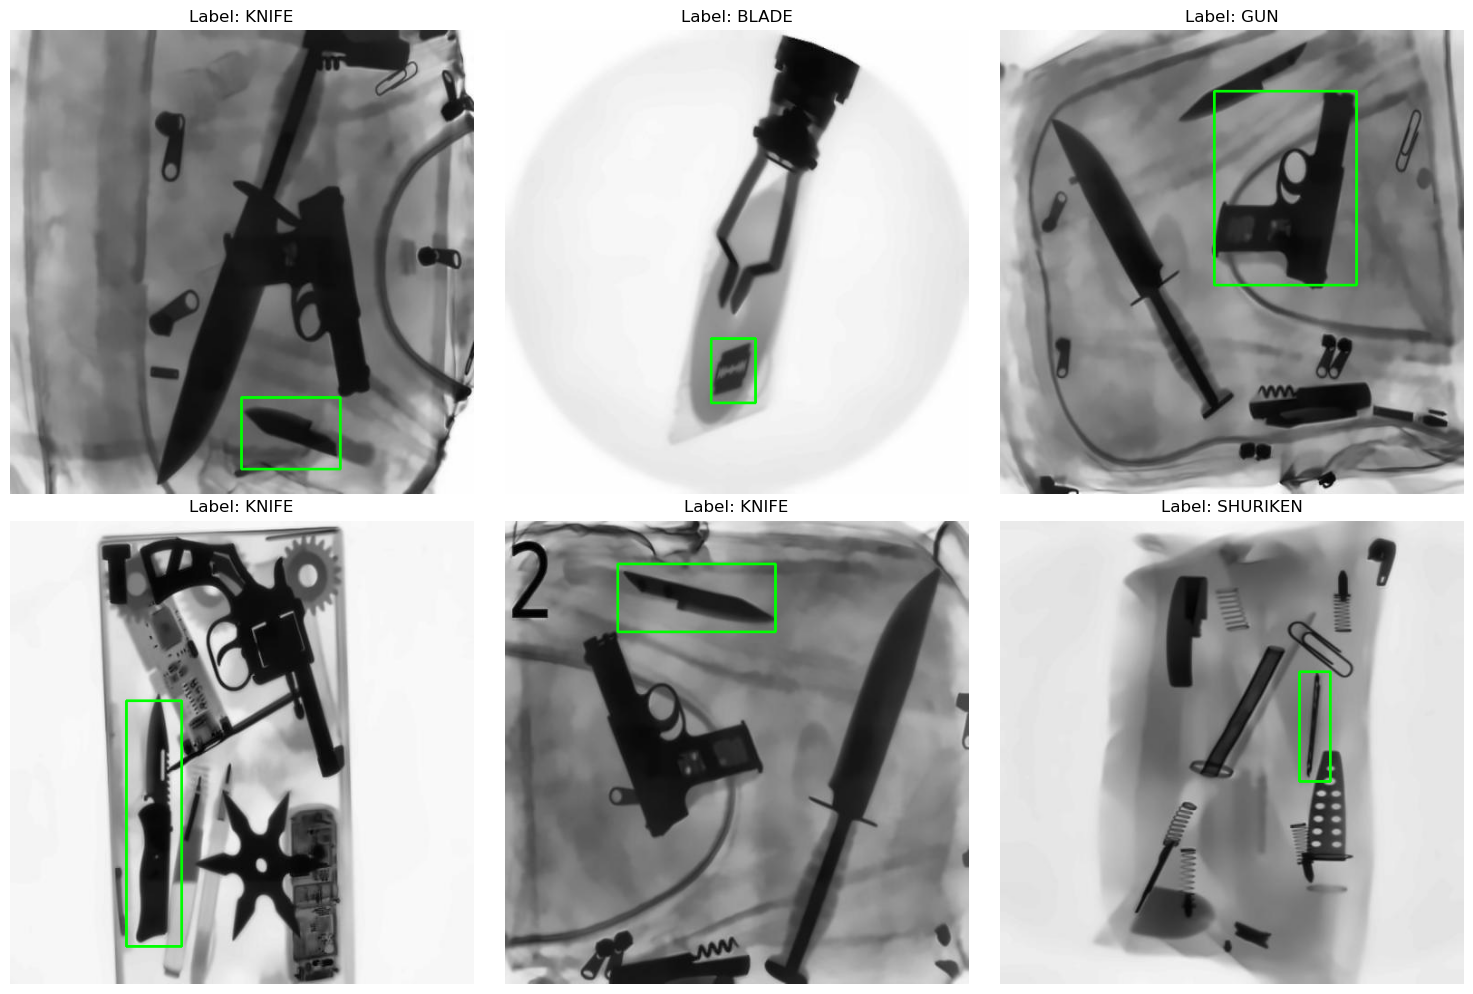

In [397]:
# Function to denormalize bounding boxes
def denormalize_bbox(bbox, image_shape):
    height, width = image_shape[:2]
    xmin, ymin, xmax, ymax = bbox
    xmin = int(xmin * width)
    ymin = int(ymin * height)
    xmax = int(xmax * width)
    ymax = int(ymax * height)
    return xmin, ymin, xmax, ymax

annotations_df = pd.read_csv('data.csv')

sampled_annotations = annotations_df.sample(n=6)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (index, row) in enumerate(sampled_annotations.iterrows()):
    image = cv2.imread(row['file_path'])

    
    bbox = [row['x_min'], row['y_min'], row['x_max'], row['y_max']]
    xmin, ymin, xmax, ymax = denormalize_bbox(bbox, image.shape)

    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    axes[i].imshow(image_rgb)
    axes[i].set_title(f"Label: {row['obj_label']}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 2.2 Google Cloud Storage


Ensure the following are installed in your local environment:
- The Google Cloud SDK (refer to Practical 2_2)
- Execute the following command to set up your Conda environment before proceeding
    - <code>conda install -c conda-forge google-cloud-aiplatform google-cloud-storage</code>
    
Refer to the assignment brief on where you can obtain your 
1. project_id (contains your admin number, ending with **small** cap letter)
2. service_account
3. service_account_key.json

In [398]:
PROJECT_ID = "i223715y"

In [399]:
# do not change
REGION = "us-central1"

### Cloud Storage bucket

When you initialize the Vertex AI SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

The name of your Cloud Storage bucket is set below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [400]:
# do not change
BUCKET_NAME = PROJECT_ID + "-3386-aip"
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [401]:
print(BUCKET_URI)

gs://i223715y-3386-aip


In [402]:
# updating the image path in the csv with BUCKET URI
annotation_df = pd.read_csv("./data.csv")
annotation_df.head(3)

,file_path,obj_label,x_min,y_min,e1,e2,x_max,y_max,e3,e4
0,threat_items_dataset/bag_0488_rf_7a2d66a2970a8f5a9756a2115bf7ae4a.jpg,GUN,0.267188,0.023438,NaN,NaN,0.720313,0.562500,NaN,NaN
1,threat_items_dataset/bag_0097_rf_6046d82290018f2373515b6fa76db364.jpg,KNIFE,0.364063,0.748437,NaN,NaN,0.701562,0.906250,NaN,NaN
2,threat_items_dataset/bag_0168_rf_b4e34b6fc9175aecfca5a0d33206ac9b.jpg,GUN,0.037500,0.401562,NaN,NaN,0.287500,0.815625,NaN,NaN


In [403]:
len(annotation_df['file_path'].unique())

143

In [404]:
annotation_df.loc[:, 'file_path'] = annotation_df["file_path"].apply(lambda x: f"{BUCKET_URI}/{x}")
annotation_df.head(3)

,file_path,obj_label,x_min,y_min,e1,e2,x_max,y_max,e3,e4
0,gs://i223715y-3386-aip/threat_items_dataset/bag_0488_rf_7a2d66a2970a8f5a9756a2115bf7ae4a.jpg,GUN,0.267188,0.023438,NaN,NaN,0.720313,0.562500,NaN,NaN
1,gs://i223715y-3386-aip/threat_items_dataset/bag_0097_rf_6046d82290018f2373515b6fa76db364.jpg,KNIFE,0.364063,0.748437,NaN,NaN,0.701562,0.906250,NaN,NaN
2,gs://i223715y-3386-aip/threat_items_dataset/bag_0168_rf_b4e34b6fc9175aecfca5a0d33206ac9b.jpg,GUN,0.037500,0.401562,NaN,NaN,0.287500,0.815625,NaN,NaN


In [405]:
annotation_df.obj_label.value_counts()

obj_label
GUN         50
KNIFE       50
BLADE       50
SHURIKEN    50
Name: count, dtype: int64

In [406]:
annotation_df.to_csv("./threat_items_dataset/data.csv", index=False)

Set up ADC to use your service account. Refer to Practical 7 for details on Google Cloud Storage setup and how to upload your images and annotation file.

In [407]:
!dir *.json

zsh:1: command not found: dir


In [408]:
%env GOOGLE_APPLICATION_CREDENTIALS

'key_i223715y.json'

In [409]:
%env GOOGLE_APPLICATION_CREDENTIALS=key_i223715y.json
%env GOOGLE_APPLICATION_CREDENTIALS

env: GOOGLE_APPLICATION_CREDENTIALS=key_i223715y.json


'key_i223715y.json'

In [420]:
storage_client = storage.Client()

try:
    my_bucket = storage_client.create_bucket(BUCKET_NAME)
except:
    print(f"{BUCKET_NAME} already created !")

In [421]:
buckets = storage_client.list_buckets()
for bucket in buckets:
    print(bucket.name)

i223715y-3386-aip


In [422]:
blobs = storage_client.list_blobs(BUCKET_NAME)
for blob in blobs:
    print(blob.name)

In [413]:
def upload_directory_with_transfer_manager(bucket, source_directory, workers=8):
    from pathlib import Path

    from google.cloud.storage import Client, transfer_manager

    # Generate a list of paths (in string form) relative to the `directory`.
    # This can be done in a single list comprehension, but is expanded into
    # multiple lines here for clarity.

    # First, recursively get all files in `directory` as Path objects.
    directory_as_path_obj = Path(source_directory)
    paths = directory_as_path_obj.rglob("*")

    # Filter so the list only includes files, not directories themselves.
    file_paths = [path for path in paths if path.is_file()]

    # These paths are relative to the current working directory. Next, make them
    # relative to `directory`
    relative_paths = [path.relative_to(source_directory) for path in file_paths]

    # Finally, convert them all to strings.
    string_paths = [str(path) for path in relative_paths]

    print("Found {} files.".format(len(string_paths)))
    
    # filenames must in forward slashes to create the corresponding folder inside bucket
    string_paths[:] = [Path(path).as_posix() for path in string_paths]
    
    # Start the upload.
    results = transfer_manager.upload_many_from_filenames(
        bucket, string_paths, source_directory=source_directory, max_workers=workers
    )

    for name, result in zip(string_paths, results):
        # The results list is either `None` or an exception for each filename in
        # the input list, in order.

        if isinstance(result, Exception):
            print("Failed to upload {} due to exception: {}".format(name, result))
        else:
            print("Uploaded {} to {}.".format(name, bucket.name))

In [414]:
len(annotation_df.file_path.unique())

143

In [415]:
target_dir = './dataset/'
source_dir = './threat_items_dataset'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    
if os.path.exists(source_dir):
    destination = os.path.join(target_dir, os.path.basename(source_dir))
    shutil.move(source_dir, destination)
    print(f"Directory moved from {source_dir} to {destination}")

Directory moved from ./threat_items_dataset to ./dataset/threat_items_dataset


In [423]:
my_bucket = next(storage_client.list_buckets())
src_dir = "./dataset/"

upload_directory_with_transfer_manager(my_bucket, src_dir)

Found 144 files.
Uploaded threat_items_dataset/bag_0100_rf_6bd0822e9d062a7244f4f3b3a2c5ce15.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_0403_rf_e7d8b41fd707e4a2c37c14b093f8cc45.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_1194_rf_8c5c494217d29374ad2ecbb996e433a9.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_0492_rf_99a0e1769b2ea665a47375018a3d2843.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_0453_1__rf_259d0c54e53fd85ef95894b591cf8d4d.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_1053_rf_2b64935274bf2e0244e1dbffcd2156d5.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_1175_rf_cb90b4079d00e8cfbcf8d89d6c24a768.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_0162_rf_869bc607df649d66306fc948c8a8119e.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_0175_rf_699956ccf5fb1f631d06bf6198c5e019.jpg to i223715y-3386-aip.
Uploaded threat_items_dataset/bag_0023_rf_f7f54dcceaf372d0ebe5acf7b8aa9

In [418]:
# delete the buckets and their data

# buckets = storage_client.list_buckets()
# for bucket in buckets:
#     blobs = bucket.list_blobs()
#     for blob in blobs: 
#         blob.delete()
#         print('{} deleted'.format(blob.name))
#     bucket.delete()

### Final check on annotation file

Inside your annotation file, every image is specified as a Cloud Storage resource path (e.g. gs://project-id/masks/123.jpg).

> Verify each resource path is valid.

Common errors:
1. Do not use spaces; use an underscore or a dash
<pre>✘ gs://s2-123456a-aip-3386/masks/image<span style="background-color: #FFFF00"> </span>1.jpg</pre>
<pre>✔ gs://s2-123456a-aip-3386/masks/image<span style="background-color: #FFFF00">_</span>1.jpg</pre>

2. Last character of project id with your admin number is small cap
<pre>✘ gs://s2-123456<span style="background-color: #FFFF00">A</span>-aip-3386/masks/baseball/1.jpg</pre>
<pre>✔ gs://s2-123456<span style="background-color: #FFFF00">a</span>-aip-3386/masks/baseball/1.jpg</pre>

In [425]:
def check_files_match_and_validate(bucket_name, dataframe, column_name="file_path"):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    bucket_files = {blob.name for blob in bucket.list_blobs() if ".csv" not in blob.name}
    dataframe_files = set(dataframe[column_name].unique())
    
    missing_in_bucket = dataframe_files - bucket_files
    missing_in_dataframe = bucket_files - dataframe_files
    
    invalid_in_bucket = {f for f in bucket_files if " " in f or any(c.isupper() for c in f)}
    invalid_in_dataframe = {f for f in dataframe_files if " " in f or any(c.isupper() for c in f)}
    
    return {
        "all_match": not missing_in_bucket and not missing_in_dataframe,
        "missing_in_bucket": missing_in_bucket,
        "missing_in_dataframe": missing_in_dataframe,
        "invalid_in_bucket": invalid_in_bucket,
        "invalid_in_dataframe": invalid_in_dataframe,
    }



data_df = pd.read_csv("data.csv")
data_df.file_path.tolist()


result = check_files_match_and_validate(BUCKET_NAME, data_df, column_name="file_path")

if result["all_match"]:
    print("All files match between the bucket and the DataFrame.")
else:
    print("Discrepancies found!")
    print("Files missing in bucket:", result["missing_in_bucket"])
    print("Files missing in DataFrame:", result["missing_in_dataframe"])

if result["invalid_in_bucket"]:
    print("Files in the bucket with invalid paths (spaces or uppercase letters):")
    print(result["invalid_in_bucket"])
else: 
    print("All files are valid in bucket.")

if result["invalid_in_dataframe"]:
    print("Files in the DataFrame with invalid paths (spaces or uppercase letters):")
    print(result["invalid_in_dataframe"])
else:
    print("All files are valid in dataframe.")

All files match between the bucket and the DataFrame.
All files are valid in bucket.
All files are valid in dataframe.
